<a href="https://colab.research.google.com/github/GreatGameDota/6DoF-Car-Detection-from-RGB-Images/blob/master/CenterNet_Hourglass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6DoF Car Detection Compeition Solution Notebook
My 177th place solution for the [6DoF Car Detection competition](https://www.kaggle.com/c/pku-autonomous-driving) hosted on Kaggle by Peking University/Baidu.

In [0]:
%tensorflow_version 1.x

In [3]:
import numpy as np
np.random.seed(2020)
import pandas as pd
import cv2
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import keras
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
import os
os.chdir('/content/')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Download dataset containing preprocessed images
Ref: https://www.kaggle.com/diegojohnson/pku-autonomous-driving-preprocess

In [5]:
import json
import zipfile
import os

!pip install kaggle --quiet

api_token = {"username":"greatgamedota","key":"8d2d163f0f1ccfe39e9c08b3da0c40fc"} # Get the key from create new api token on https://www.kaggle.com/greatgamedota/account
!mkdir /root/.kaggle # create a dir for key
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json # make sure no one else can read the key

if not os.path.isdir('train_images/'):
  !kaggle datasets download -d diegojohnson/pku-autonomous-driving-preprocess

  !unzip -q pku-autonomous-driving-preprocess.zip
  !rm pku-autonomous-driving-preprocess.zip
  !rm train.csv

  !mv test/ test_images/
  !mv train/ train_images/

100% 8.02G/8.03G [03:18<00:00, 30.6MB/s]
100% 8.03G/8.03G [03:18<00:00, 43.4MB/s]


In [0]:
train_df = pd.read_csv('drive/My Drive/train.csv')
train_df = train_df.set_index(['ImageId'])

In [0]:
IMAGE_PATH = 'train_images/'
image_dims = (512, 512, 3)
reshape = (512, 512)
reshape_channels = (*reshape, 3)

BATCH_SIZE = 1
EPOCHS = 1
num_classes = 1

train_images = next(os.walk(IMAGE_PATH))[2]
train_images.sort()

test_images = pd.read_csv('drive/My Drive/sample_submission.csv')
test_images = test_images.drop(['PredictionString'], axis=1)

# Next three cells are for util functions
- Letterbox transform class and more
- Horizontal flip util function
- Preprocess input functions

In [0]:
def normalize_image(image):
  """Normalize the image for the Hourglass network.
  # Arguments
    image: BGR uint8
  # Returns
    float32 image with the same shape as the input
  """
  mean = [0.40789655, 0.44719303, 0.47026116]
  std = [0.2886383, 0.27408165, 0.27809834]
  return ((np.float32(image) / 255.) - mean) / std

def training_transform(height, width, output_height, output_width):
  # https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html
  height_scale, width_scale = output_height / height, output_width / width
  scale = min(height_scale, width_scale)
  resize_height, resize_width = round(height * scale), round(width * scale)
  pad_top = (output_height - resize_height) // 2
  pad_left = (output_width - resize_width) // 2
  # print(pad_top)
  A = np.float32([[scale, 0.0], [0.0, scale]])
  B = np.float32([[pad_left], [pad_top]])
  M = np.hstack([A, B])
  return M, output_height, output_width

def testing_transform(height, width, max_stride):
  h_pad, w_pad = round(height / max_stride + 0.51) * max_stride, round(width / max_stride + 0.51) * max_stride
  pad_left = (w_pad - width) // 2
  pad_top = (h_pad - height) // 2
  A = np.eye(2, dtype='float32')
  B = np.float32([[pad_left], [pad_top]])
  M = np.hstack([A, B])
  return M, h_pad, w_pad

def invert_transform(M):
  # T = A @ x + B => x = A_inv @ (T - B) = A_inv @ T + (-A_inv @ B)
  A_inv = np.float32([[1. / M[0, 0], 0.0], [0.0, 1. / M[1, 1]]])
  B_inv = -A_inv @ M[:, 2:3]
  M_inv = np.hstack([A_inv, B_inv])
  return M_inv

def affine_transform_coords(coords, M):
  A, B = M[:2, :2], M[:2, 2:3]
  transformed_coords = A @ coords + B
  return transformed_coords

class LetterboxTransformer:
  def __init__(self, height=None, width=None, mode='training', max_stride=128):
    """Resize the input images. For `mode='training'` the resolution is fixed to `height` x `width`.
       The resolution is changed but the aspect ratio is kept.
       In `mode='testing'` the input is padded to the next bigger multiple of `max_stride` of the network.
       The orginal resolutions is thus kept."""
    self.height = height
    self.width = width
    self.mode = mode
    self.max_stride = max_stride
    self.M = None
    self.M_inv = None

  def __call__(self, image):
    h, w = image.shape[:2]
    if self.mode == 'training':
      M, h_out, w_out = training_transform(h, w, self.height, self.width)
    elif self.mode == 'testing':
      M, h_out, w_out = testing_transform(h, w, self.max_stride)

    # https://answers.opencv.org/question/33516/cv2warpaffine-results-in-an-image-shifted-by-05-pixel
    # This is different from `cv2.resize(image, (resize_width, resize_height))` & pad
    letterbox = cv2.warpAffine(image, M, (w_out, h_out))
    self.M = M
    self.M_inv = invert_transform(M)
    return letterbox

  def correct_box(self, x1, y1, x2, y2):
    coords = np.float32([[x1, x2], [y1, y2]])
    coords = affine_transform_coords(coords, self.M_inv)
    x1, y1, x2, y2 = coords[0, 0], coords[1, 0], coords[0, 1], coords[1, 1]
    return x1, y1, x2, y2

  def correct_coords(self, coords):
    coords = affine_transform_coords(coords, self.M_inv)
    return coords

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

def flip_hor_at_u(img, cx, flag_plot=False):
    # determine line for flipping rounded to 0.5 pixel
    cx_rounded = np.round(cx * 2).astype(np.int)
    u_flip = cx_rounded / 2

    # determine new width
    height, width, nchannels = img.shape
    if cx_rounded % 2 == 1:
        # if flipping line lies between two pixels...
        width_left = np.ceil(u_flip)
        width_right = np.floor(width - u_flip)
        width_new = 2 * max(width_left, width_right)
        pad_left = width_new / 2 - width_left
        pad_right = width_new / 2 - width_right
    else:
        # if flipping line lies at a pixel...
        width_left = np.round(u_flip)
        width_right = np.round(width - u_flip - 1)
        width_new = 2 * max(width_left, width_right) + 1
        pad_left = (width_new - 1) / 2 - width_left
        pad_right = (width_new - 1) / 2 - width_right

    # create new image and flip horizontally
    bg = img.mean(1, keepdims=True).astype(img.dtype)
    bg_left = np.repeat(bg, pad_left, axis=1)
    bg_right = np.repeat(bg, pad_right, axis=1)
    img_padded = np.hstack((bg_left, img, bg_right))
    img_padded_flipped = img_padded[:, ::-1, :]

    # crop back to org size s.t. cx=const
    dim_right = width_new-pad_right
    img_cropped = img_padded_flipped[:,
                  pad_left.astype(np.int):dim_right.astype(np.int)
                  :]
    width_cropped = img_cropped.shape[1]
    assert width_cropped== width, "width changed during flipping ?!"

    # plot images
    if flag_plot:
        fig_width, fig_height = max(4,width/100), max(6, 2*height/100)
        fig,ax = plt.subplots(2,1, sharey=True, sharex=True, figsize=(fig_width,fig_height))
        ax[0].imshow(img)
        ax[1].imshow(img_cropped)
        for axi in ax:
            axi.vlines(u_flip, 0, height-1)
        plt.show()

    return img_cropped

In [0]:
from math import sin, cos, floor

IMG_WIDTH = reshape[1]
IMG_HEIGHT = reshape[0]
MODEL_SCALE = 1

camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys, img_zs

def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 1
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    # print(regr_dict)
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 1
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def get_regr(img, labels, flip=False):
    height = img.shape[0]
    width = img.shape[1]
    regr = np.zeros((height // MODEL_SCALE, width // MODEL_SCALE, 5), dtype='float32')
    coords = str2coords(labels)
    xs, ys, zs = get_img_coords(labels)

    coors = []
    # size = int((1000/z) // 1.5) # Change size based on z (move this into loop to work)
    size = 30
    y_ = size
    while y_ > -size - 1:
      x_ = -size
      while x_ < size + 1:
        coors.append([x_, y_])
        x_ += 1
      y_ -= 1

    for x, y, regr_dict, z in zip(xs, ys, coords, zs):
        x, y = y, x
        x = np.round(x).astype('int')
        y = np.round(y).astype('int')
        if True:
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr_dict.pop('x')
            regr_dict.pop('y')
            for coor in coors:
              try:
                regr[x+coor[0], y+coor[1]] = [regr_dict[n] for n in regr_dict]
              except:
                pass
    if flip:
        regr = flip_hor_at_u(regr, 1686.2379, flag_plot=False)

    regr_ = []
    for i in list(range(regr.shape[-1])):
      temp = letterbox_transformer(regr[:,:,i])
      regr_.append(cv2.resize(temp, (reshape[1]//4,reshape[0]//4)))

    return np.rollaxis(np.array(regr_), 0, 3)

def heatmap(u, v, z, output_width=IMG_WIDTH // MODEL_SCALE, output_height=IMG_HEIGHT // MODEL_SCALE, sigma=1):
    def get_heatmap(p_x, p_y, p_z):
        # Ref: https://www.kaggle.com/diegojohnson/centernet-objects-as-points
        X1 = np.linspace(1, output_width, output_width)
        Y1 = np.linspace(1, output_height, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        sigma_ = (1000/p_z) / 1.75
        E2 = 2.0 * sigma_ ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap

    coors = []
    size = 20
    y_ = size
    while y_ > -size - 1:
      x_ = -size
      while x_ < size + 1:
        coors.append([x_, y_])
        x_ += 1
      y_ -= 1

    output = np.zeros((output_height,output_width,1))
    for i in range(len(u)):
      for coor in coors:
        try:
          output[int(v[i])+coor[0], int(u[i])+coor[1]] = 1
        except:
          pass
        # heatmap = get_heatmap(u[i], v[i], z[i])
        # output[:,:] = np.maximum(output[:,:],heatmap[:,:])
      
    return output

# Test if input and mask functions work

img.shape (512, 512, 3) std: 101.84918285899175
mask.shape (128, 128) std: 0.030718861387512574
regr.shape (128, 128, 5) std: 0.60295004


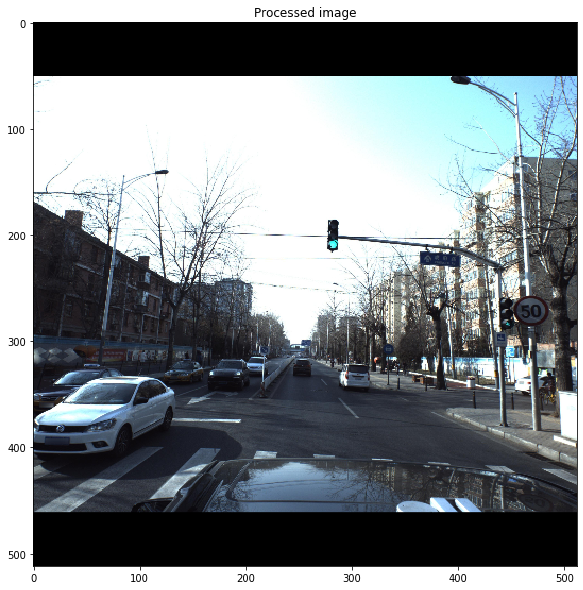

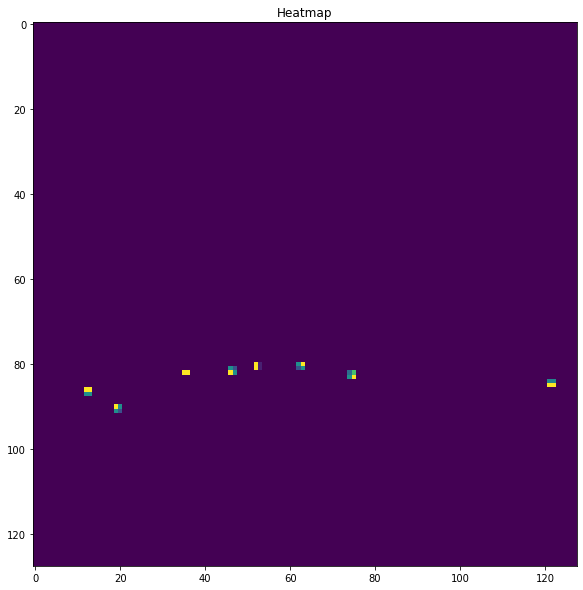

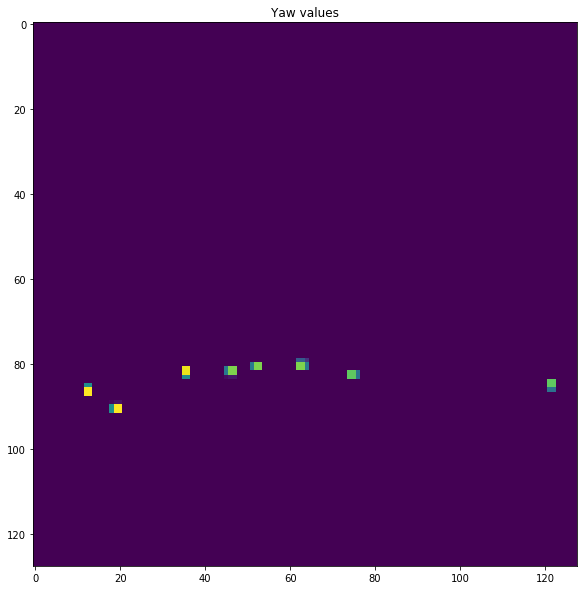

In [16]:
letterbox_transformer = LetterboxTransformer(reshape[0], reshape[1])
img0 = cv2.cvtColor(cv2.imread(f'{IMAGE_PATH}{train_images[1]}'), cv2.COLOR_BGR2RGB)
img = letterbox_transformer(img0)

xs, ys, zs = get_img_coords(train_df.loc[train_images[1][:-4]]['PredictionString'])
mask_ = heatmap(xs, ys, zs, output_height=2710, output_width=3384, sigma=25)
mask_ = letterbox_transformer(mask_)
mask_ = cv2.resize(mask_, (reshape[1]//4,reshape[0]//4))

regr = get_regr(img0, train_df.loc[train_images[1][:-4]]['PredictionString'])

print('img.shape', img.shape, 'std:', np.std(img))
print('mask.shape', mask_.shape, 'std:', np.std(mask_))
print('regr.shape', regr.shape, 'std:', np.std(regr))

plt.figure(figsize=(10,10))
plt.title('Processed image')
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.title('Heatmap')
plt.imshow(mask_)
plt.show()

plt.figure(figsize=(10,10))
plt.title('Yaw values')
plt.imshow(regr[:,:,0])
plt.show()

# Keras DataGenerator class with augmentations

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=IMAGE_PATH, image_paths=None,
                 batch_size=4, dim=(128, 128), n_channels=3,
                 n_classes=3, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.image_paths = image_paths
        self.letterbox_transformer = LetterboxTransformer(dim[0], dim[1])
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        if np.random.randint(0,25) < 2: # This only works with batch_size of 1
          flip = True
        else:
          flip = False

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch, flip)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, flip)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch, flip=False):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.image_paths[ID]
            img_path = f"{self.base_path}{im_name}"
            img = self.__load_rgb(img_path, flip)
            
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch, flip=False):
        y = []
        for i, ID in enumerate(list_IDs_batch):
            img = np.zeros((2710,3384,3))
            xs, ys, zs = get_img_coords(self.df.loc[self.image_paths[ID][:-4]]['PredictionString'])
            mask = heatmap(xs, ys, zs, output_height=2710, output_width=3384, sigma=25)
            if flip:
              mask = flip_hor_at_u(mask, 1686.2379, flag_plot=False)
            mask = self.letterbox_transformer(mask)
            mask = cv2.resize(mask, (reshape[1]//4,reshape[0]//4))
            mask = mask[:,:, np.newaxis]

            regr = get_regr(img, self.df.loc[self.image_paths[ID][:-4]]['PredictionString'], flip)
            
            y.append(np.concatenate([mask,regr], axis=-1))
        
        y = np.array(y)
        return [y]
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path, flip):
        img = Image.open(img_path)

        if np.random.randint(0,10) < 5:
          enh = ImageEnhance.Contrast(img)
          img = enh.enhance(np.random.uniform(1.5, 2)) # Contrast
        elif np.random.randint(0,10) < 4:
          enh = ImageEnhance.Contrast(img)
          img = enh.enhance(np.random.uniform(0.5, 1)) # Brightness
        img = np.asarray(img)
        if flip:
          img = flip_hor_at_u(img, 1686.2379, flag_plot=False)
        img = self.letterbox_transformer(img)[:,:,::-1]

        img = normalize_image(img)
        return img

# Test if augmentations work

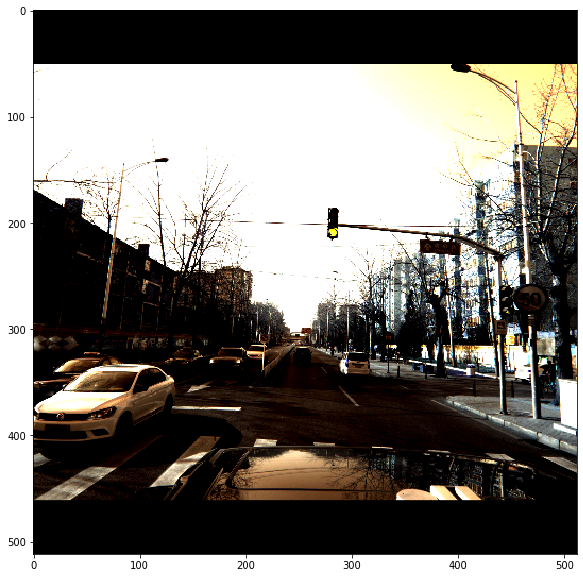

In [13]:
letterbox_transformer = LetterboxTransformer(reshape[0], reshape[1])

for i in range(1):
  img = Image.open(f'{IMAGE_PATH}{train_images[1]}')
  if np.random.randint(0,10) < 4:
    enh = ImageEnhance.Contrast(img)
    img = enh.enhance(np.random.uniform(1.5, 2))
  if np.random.randint(0,10) < 5:
    enh = ImageEnhance.Contrast(img)
    img = enh.enhance(np.random.uniform(0.5, 1))
  img = np.asarray(img)
  if np.random.randint(0,25) < 2:
    img = flip_hor_at_u(img, 1686.2379, flag_plot=False)
  img = letterbox_transformer(img)[:,:,::-1]

  plt.figure(figsize=(10,10))
  plt.imshow(img)

# Build Keras Centernet model

In [19]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense, Activation, Input, Conv2D, BatchNormalization, Add, UpSampling2D, ZeroPadding2D, Lambda, Concatenate, Dropout, SpatialDropout2D
from keras.models import Sequential, Model
from keras.utils import get_file

weights_path = get_file('centernet.hdf5',
                          'https://github.com/see--/keras-centernet/releases/download/0.1.0/ctdet_coco_hg.hdf5',
                          cache_subdir='/content/', 
                          file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')

def HourglassNetwork(heads, num_stacks, cnv_dim=256, inres=(512, 512), weights_path='centernet.hdf5',
                     dims=[256, 384, 384, 384, 512]):
    """Instantiates the Hourglass architecture.
    Optionally loads weights pre-trained on COCO.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
      num_stacks: number of hourglass modules.
      cnv_dim: number of filters after the resolution is decreased.
      inres: network input shape, should be a multiple of 128.
      weights: one of `None` (random initialization),
            'ctdet_coco' (pre-training on COCO for 2D object detection),
            'hpdet_coco' (pre-training on COCO for human pose detection),
            or the path to the weights file to be loaded.
      dims: numbers of channels in the hourglass blocks.
    # Returns
      A Keras model instance.
    # Raises
      ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
    """
    
    input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
    inter = pre(input_layer, cnv_dim)
    prev_inter = None
    outputs = []
    for i in range(num_stacks):
        prev_inter = inter
        _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims)
        if i == 1:
            if _heads is not None:
                outputs.extend(_heads)
        if i < num_stacks - 1:
            inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
            inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.1' % i)(inter_)

            cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
            cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.1' % i)(cnv_)

            inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
            inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
            inter = residual(inter, cnv_dim, 'inters.%d' % i)

    model = Model(inputs=input_layer, outputs=outputs)

    # load weights
    print('Loading weights...')
    model.load_weights(weights_path, by_name=True)
    print('Done!')

    return model

def hourglass_module(heads, bottom, cnv_dim, hgid, dims):
    # create left features , f1, f2, f4, f8, f16 and f32
    lfs = left_features(bottom, hgid, dims)

    # create right features, connect with left features
    rf1 = right_features(lfs, hgid, dims)
    rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)

    # add 1x1 conv with two heads, inter is sent to next stage
    # head_parts is used for intermediate supervision
    if heads is not None:
        heads = create_heads(heads, rf1, hgid)
    return heads, rf1

def convolution(_x, k, out_dim, name, stride=1):
    padding = (k - 1) // 2
    _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
    _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

def residual(_x, out_dim, name, stride=1):
    shortcut = _x
    num_channels = K.int_shape(shortcut)[-1]
    _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
    _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
    _x = Activation('relu', name=name + '.relu1')(_x)

    _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)

    if num_channels != out_dim or stride != 1:
        shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
            shortcut)
        shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.1')(shortcut)

    _x = Add(name=name + '.add')([_x, shortcut])
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

def pre(_x, num_channels):
    # front module, input to 1/4 resolution
    _x = convolution(_x, 7, 128, name='pre.0', stride=2)
    _x = residual(_x, num_channels, name='pre.1', stride=2)
    return _x

def left_features(bottom, hgid, dims):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8, f16, f32 : 1, 1/2, 1/4 1/8, 1/16, 1/32 resolution
    # 5 times reduce/increase: (256, 384, 384, 384, 512)
    features = [bottom]
    for kk, nh in enumerate(dims):
        pow_str = ''
        for _ in range(kk):
            pow_str += '.center'
        _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=2)
        _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
        features.append(_x)
    return features

def connect_left_right(left, right, num_channels, num_channels_next, name):
    # left: 2 residual modules
    left = residual(left, num_channels_next, name=name + 'skip.0')
    left = residual(left, num_channels_next, name=name + 'skip.1')

    # up: 2 times residual & nearest neighbour
    out = residual(right, num_channels, name=name + 'out.0')
    out = residual(out, num_channels_next, name=name + 'out.1')
    out = UpSampling2D(name=name + 'out.upsampleNN')(out)
    out = Add(name=name + 'out.add')([left, out])
    return out

def bottleneck_layer(_x, num_channels, hgid):
    # 4 residual blocks with 512 channels in the middle
    pow_str = 'center.' * 5
    _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
    return _x

def right_features(leftfeatures, hgid, dims):
    rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
    for kk in reversed(range(len(dims))):
        pow_str = ''
        for _ in range(kk):
            pow_str += 'center.'
        rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
    return rf

def create_heads(heads, rf1, hgid):
    _heads = []
    for head in heads:
        num_channels = heads[head]
        _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
        _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
        _x = Conv2D(num_channels, 1, use_bias=True, name=head + '.%d.1' % hgid)(_x)
        _heads.append(_x)
    return _heads

kwargs = {
        'num_stacks': 2,
        'cnv_dim': 256,
        'inres': reshape,
        'weights_path': 'drive/My Drive/Models/hourglass1-3 (.167).h5'
        # 'weights_path': 'drive/My Drive/Models/weights2.h5'
        }
heads = {
        'regr': 5,
        'confidence': 1
        }
model = HourglassNetwork(heads=heads, **kwargs)

Loading weights...
Done!


In [0]:
concat = Concatenate() ([model.layers[-1].output, model.layers[-2].output])
model = Model(model.input, concat)

# Define loss functions and compile model with optimizer

In [0]:
# Ref: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
alpha = .25
gamma = 2
def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
  weight_a = alpha * (1 - y_pred) ** gamma * targets
  weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
  return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

def focal_loss(y_true, y_pred):
  y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
  logits = tf.log(y_pred / (1 - y_pred))

  loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

  # or reduce_sum and/or axis=-1
  return tf.reduce_mean(loss)

from keras.losses import binary_crossentropy

def criterion(y_true, y_pred):
    mask = y_true[:,:,:, 0][:,:,:,np.newaxis]
    regr = y_true[:,:,:, 1:]
    prediction = y_pred

    # Binary mask loss
    pred_mask = tf.sigmoid(prediction[:,:,:, 0])[:,:,:,np.newaxis]
    mask_loss = focal_loss(mask, pred_mask)
    # mask_loss = binary_crossentropy(mask, pred_mask)
    # mask_loss = tf.reduce_mean(mask_loss)

    # Regression L1 loss
    pred_regr = prediction[:,:,:, 1:]
    regr_loss = tf.reduce_sum(tf.reduce_sum((tf.reduce_sum(tf.abs(pred_regr - regr),1) * mask),1),1) / tf.reduce_sum(tf.reduce_sum(mask,1),1)
    regr_loss = tf.reduce_mean(regr_loss, 0)
    # Sum
    loss = mask_loss + regr_loss
    return loss

from keras.optimizers import Adam
opt = Adam(lr=.001)
model.compile(optimizer=opt, loss=criterion)

# Implement CV callback

In [0]:
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

def img_2_world(x, y, z=1):
  xc, yc, zc = x*z, y*z, z
  p_cam = np.array([xc,yc,zc])
  xw, yw, zw = np.dot(np.linalg.inv(k), p_cam)
  return np.array([xw, yw, zw])

def _nms(heat, kernel=3):
  hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
  keep = K.cast(K.equal(hmax, heat), K.floatx())
  return heat * keep

def decode_ddd(regr_, hm_, k=50, output_stride=4):
  hm = K.sigmoid(K.expand_dims(regr_[:,:,:,0]))
  regr = regr_[:,:,:,1:]
  hm = _nms(hm)
  hm_shape = K.shape(hm)
  regr_shape = K.shape(regr)
  batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

  hm_flat = K.reshape(hm, (batch, -1))
  regr_flat = K.reshape(regr, (regr_shape[0], -1, regr_shape[-1]))

  def _process_sample(args):
    _hm, _regr = args
    _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
    _classes = K.cast(_inds % cat, 'float32')
    _inds = K.cast(_inds / cat, 'int32')
    _xs = K.cast(_inds % width, 'float32')
    _ys = K.cast(K.cast(_inds / width, 'int32'), 'float32')
    _xs *= output_stride
    _ys *= output_stride

    _regr = K.gather(_regr, _inds)

    _yaw = _regr[:,0]
    _roll = rotate(_regr[:,1], -np.pi)
    _z = _regr[:,2]
    _pitch_sin = _regr[:,3]
    _pitch_cos = _regr[:,4]

    _detection = K.stack([_xs, _ys, _scores, _classes, _yaw, _roll, _z, _pitch_sin, _pitch_cos], -1)
    return _detection

  detections = K.map_fn(_process_sample, [hm_flat, regr_flat], dtype=K.floatx())
  return detections

def add_decoder(model, idxs, k=50, output_stride=4):
  def _decode(args):
    _regr = args
    return decode_ddd(_regr, None, k=k, output_stride=output_stride)
  output = Lambda(_decode)(model.outputs[0])
  model = Model(model.input, output)
  return model

import numpy as np
import pandas as pd
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords_(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)

    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

def print_pr_curve(result_flg, scores, recall_total=1):
    average_precision = average_precision_score(result_flg, scores)
    precision, recall, _ = precision_recall_curve(result_flg, scores)
    recall *= recall_total
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx, train_d, valid_df):
      keep_gt=False
      thre_tr_dist = thres_tr_list[idx]
      thre_ro_dist = thres_ro_list[idx]
      train_dict = {imgID:str2coords_(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_d['ImageId'],train_d['PredictionString'])}
      valid_dict = {imgID:str2coords_(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
      result_flg = [] # 1 for TP, 0 for FP
      scores = []
      MAX_VAL = 10**10
      for img_id in valid_dict:
          for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
              # find nearest GT
              min_tr_dist = MAX_VAL
              min_idx = -1
              for idx, gcar in enumerate(train_dict[img_id]):
                  tr_dist = TranslationDistance(pcar,gcar)
                  if tr_dist < min_tr_dist:
                      min_tr_dist = tr_dist
                      min_ro_dist = RotationDistance(pcar,gcar)
                      min_idx = idx
              # set the result
              if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                  if not keep_gt:
                      train_dict[img_id].pop(min_idx)
                  result_flg.append(1)
              else:
                  result_flg.append(0)
              scores.append(pcar['carid_or_score'])
      
      return result_flg, scores

def calcmAP(model, thres=0.2):
  model_ = add_decoder(model, [0])

  df_list = []
  idxs = val_idx

  for i in trange(len(idxs)):
    test_image = f'train_images/{train_images[idxs[i]]}'

    img = cv2.imread(test_image)
    img = letterbox_transformer(img)
    img = normalize_image(img)
    out = model_.predict(img[np.newaxis])

    final = []
    for i,val in enumerate(out[0]):
      if val[3] == 0 and val[2] > thres:
        val_ = val.copy()
        val_[-1] = min(max(val_[-1],-1),1)

        pitch_sin = val_[-2] / np.sqrt(val_[-2]**2 + val_[-1]**2)
        pitch_cos = val_[-1] / np.sqrt(val_[-2]**2 + val_[-1]**2)
        pitch = np.arccos(pitch_cos) * np.sign(pitch_sin)
        val_ = np.append(val_, pitch)

        x = val_[0]*6.6
        y = (val_[1]-50)*6.6
        x,y,z = img_2_world(x,y,val_[6])
        final.append([val_[4],val_[-1],val_[5],x,y,z,val_[2]])

    final = np.array(final)
    DIST_THRES = 2
    delete = []
    for i,val in enumerate(final):
      if i not in delete:
        xyz1 = np.array([val[3],val[4],val[5]])
        for j,val2 in enumerate(final):
          if i != j:
            xyz2 = np.array([val2[3],val2[4],val2[5]])
            distance = np.sqrt(np.sum(((xyz1 - xyz2)**2)))
            if distance < DIST_THRES:
              delete.append(j)
    delete = np.unique(delete)
    final = np.delete(final, delete, axis=0)

    if len(final) > 0:
      str_final = ''
      for pred in final:
        for val in pred:
          str_final += str(val) + ' '
      str_final = str_final[:-1]
      df_list.append(str_final)
    else:
      df_list.append(np.nan)

  df = pd.DataFrame(data=df_list, columns=['PredictionString'])
  train_images_ = pd.DataFrame(data=[train_images[i][:-4] for i in idxs], columns=['ImageId'])
  preds = pd.concat([train_images_, df], sort=False, axis=1)

  valid_df = preds
  expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
  valid_df = valid_df.fillna('')

  train_d = pd.read_csv('drive/My Drive/train.csv')
  train_d = train_d[train_d.ImageId.isin(valid_df.ImageId.unique())]
  expanded_train_df = expand_df(train_d, ['model_type','pitch','yaw','roll','x','y','z'])

  max_workers = 10
  n_gt = len(expanded_train_df)
  ap_list = []
  # p = Pool(processes=max_workers)
  for i in trange(10):
  # for result_flg, scores in p.imap(check_match, (range(10), train_d, valid_df)):
      result_flg, scores = check_match(i, train_d, valid_df)
      if np.sum(result_flg) > 0:
          n_tp = np.sum(result_flg)
          recall = n_tp/n_gt
          ap = average_precision_score(result_flg, scores)*recall
          # print_pr_curve(result_flg, scores, recall)
      else:
          ap = 0
      ap_list.append(ap)
  map = np.mean(ap_list)
  return map

In [0]:
class SaveBestmAP(tf.keras.callbacks.Callback):
  def __init__(self, path):
    super(SaveBestmAP, self).__init__()
    self.best_weights = None
    self.path = path

  def on_train_begin(self, logs=None):
    self.best = 0

  def on_epoch_end(self, epoch, logs=None):
    current = calcmAP(self.model)
    if np.greater(current, self.best):
      self.best = current
      self.best_weights = self.model.get_weights()
      print(f'Best mAP: {current}, saving...')
      self.model.save_weights(self.path)
    else:
      print(f'Current mAP: {current}')
  
  def on_train_end(self, logs=None):
    print(f'Loading best model...')
    self.model.load_weights(self.path)

# Start training

In [0]:
train_idx, val_idx = train_test_split(
    list(range(len(train_images))), random_state=2019, test_size=0.2
)

# train_idx = list(range(len(train_images)))

from keras.callbacks import ReduceLROnPlateau

train_gen = DataGenerator(
    train_idx, 
    df=train_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    dim=reshape,
    n_classes=num_classes,
    image_paths=train_images
)

val_gen = DataGenerator(
    val_idx, 
    df=train_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    dim=reshape,
    n_classes=num_classes,
    image_paths=train_images,
    shuffle=False
)

checkpoint1 = ModelCheckpoint(
    'drive/My Drive/Models/hourglass1.h5',
    monitor='loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

checkpoint2 = ModelCheckpoint(
    'drive/My Drive/Models/hourglass1-2.h5',
    monitor='loss', 
    verbose=0, 
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)

reducelr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.25,
    patience=2,
    min_lr=0.000001,
    verbose=1
)

savemAP = SaveBestmAP('drive/My Drive/Models/hourglass1-3.h5')

EPOCHS = 25

history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[reducelr, checkpoint1, checkpoint2],
    use_multiprocessing=False,
    workers=1
)

In [24]:
calcmAP(model)

100%|██████████| 10/10 [02:54<00:00, 18.60s/it]


0.16724791322426208

# Visualization util functions
Ref: https://www.kaggle.com/hocop1/centernet-baseline

In [0]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image

def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        if p_x > image.shape[1] or p_y > image.shape[0]:
            print('Point', p_x, p_y, 'is out of image with shape', image.shape)
            pass
        cv2.circle(image, (p_x, p_y), 15, (0, 255, 0), -1)
    return image

def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

def str_list_2_dict(coords):
  coors = []
  for i in range(len(coords)//7):
    dict_ = {
        'yaw': float(coords[0+(i*7)]),
        'pitch': float(coords[1+(i*7)]),
        'roll': float(coords[2+(i*7)]),
        'x': float(coords[3+(i*7)]),
        'y': float(coords[4+(i*7)]),
        'z': float(coords[5+(i*7)])
    }
    coors.append(dict_)
  return coors

# Build inference model

In [0]:
def _nms(heat, kernel=3):
  hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
  keep = K.cast(K.equal(hmax, heat), K.floatx())
  return heat * keep

def decode_ddd(regr_, hm_, k=50, output_stride=4):
  hm = K.sigmoid(K.expand_dims(regr_[:,:,:,0]))
  regr = regr_[:,:,:,1:]
  hm = _nms(hm)
  hm_shape = K.shape(hm)
  regr_shape = K.shape(regr)
  batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

  hm_flat = K.reshape(hm, (batch, -1))
  regr_flat = K.reshape(regr, (regr_shape[0], -1, regr_shape[-1]))

  def _process_sample(args):
    _hm, _regr = args
    _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
    _classes = K.cast(_inds % cat, 'float32')
    _inds = K.cast(_inds / cat, 'int32')
    _xs = K.cast(_inds % width, 'float32')
    _ys = K.cast(K.cast(_inds / width, 'int32'), 'float32')
    _xs *= output_stride
    _ys *= output_stride

    _regr = K.gather(_regr, _inds)

    _yaw = _regr[:,0]
    _roll = rotate(_regr[:,1], -np.pi)
    _z = _regr[:,2]
    _pitch_sin = _regr[:,3]
    _pitch_cos = _regr[:,4]

    _detection = K.stack([_xs, _ys, _scores, _classes, _yaw, _roll, _z, _pitch_sin, _pitch_cos], -1)
    return _detection

  detections = K.map_fn(_process_sample, [hm_flat, regr_flat], dtype=K.floatx())
  return detections

def add_decoder(model, idxs, k=50, output_stride=4):
  def _decode(args):
    _regr = args
    return decode_ddd(_regr, None, k=k, output_stride=output_stride)
  output = Lambda(_decode)(model.outputs[0])
  model = Model(model.input, output)
  return model

model_ = add_decoder(model, [0])

# Compile submission

In [27]:
df_list = []
total_cars = 0

# test_image = f'test_images/{test_images.loc[test_images.index[3],:][0]}.jpg'
# for i in range(1):

for i in trange(len(test_images)):
  test_image = f'test_images/{test_images.loc[test_images.index[i],:][0]}.jpg'

  img = cv2.imread(test_image)
  img = letterbox_transformer(img)
  img = normalize_image(img)
  out = model_.predict(img[np.newaxis])

  final = []
  for i,val in enumerate(out[0]):
    if val[3] == 0 and val[2] > 0.25:
      val_ = val.copy()
      val_[-1] = min(max(val_[-1],-1),1)

      pitch_sin = val_[-2] / np.sqrt(val_[-2]**2 + val_[-1]**2)
      pitch_cos = val_[-1] / np.sqrt(val_[-2]**2 + val_[-1]**2)
      pitch = np.arccos(pitch_cos) * np.sign(pitch_sin)
      val_ = np.append(val_, pitch)

      x = val_[0]*6.6
      y = (val_[1]-50)*6.6
      x,y,z = img_2_world(x,y,val_[6])
      final.append([val_[4],val_[-1],val_[5],x,y,z,val_[2]])

  final = np.array(final)
  DIST_THRES = 2
  delete = []
  for i,val in enumerate(final):
    if i not in delete:
      xyz1 = np.array([val[3],val[4],val[5]])
      for j,val2 in enumerate(final):
        if i != j:
          xyz2 = np.array([val2[3],val2[4],val2[5]])
          distance = np.sqrt(np.sum(((xyz1 - xyz2)**2)))
          if distance < DIST_THRES:
            delete.append(j)
  delete = np.unique(delete)
  final = np.delete(final, delete, axis=0)
  total_cars += len(final)

  if len(final) > 0:
    str_final = ''
    for pred in final:
      for val in pred:
        str_final += str(val) + ' '
    str_final = str_final[:-1]
    df_list.append(str_final)
  else:
    df_list.append(np.nan)

df = pd.DataFrame(data=df_list)
preds = pd.concat([test_images, df], sort=False, axis=1)
preds = preds.rename({0: 'PredictionString'}, axis=1)
preds.to_csv(r'drive/My Drive/submission.csv', index=False)

print('')
print(total_cars)
preds.head()

100%|██████████| 2021/2021 [08:21<00:00,  4.12it/s]


22434


,ImageId,PredictionString
0,ID_18fb86d04,0.15764740109443665 0.028841806624190853 -3.10...
1,ID_ce06d4dc1,0.1542968451976776 0.028169867272403226 -3.102...
2,ID_afe07078f,0.15016944706439972 3.1077147771675664 -3.1239...
3,ID_37caf75aa,0.14940641820430756 0.011008570516046718 -3.09...
4,ID_7655363ca,0.15356136858463287 3.1117390651774475 -3.1265...


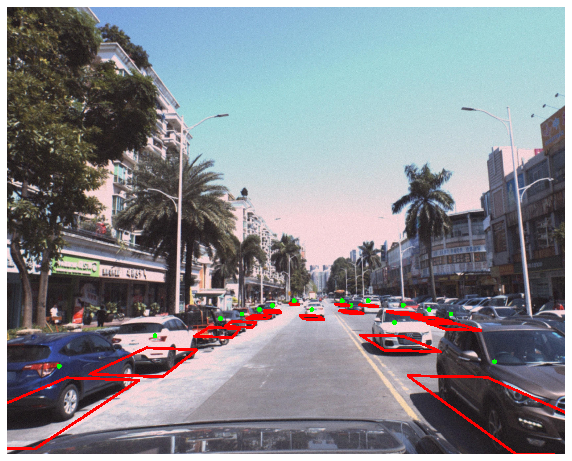

In [31]:
coords_pred_ = str_list_2_dict(df_list[-1].split(' '))

img_ = cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.axis('off')
img_ = visualize(img_, coords_pred_)

plt.imshow(img_)